Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from pathlib import Path

In [2]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech


  0%|          | 0.00/1.89M [00:00<?, ?B/s]
 53%|█████▎    | 1.00M/1.89M [00:01<00:01, 643kB/s]
100%|██████████| 1.89M/1.89M [00:03<00:00, 620kB/s]
100%|██████████| 1.89M/1.89M [00:03<00:00, 623kB/s]


In [14]:
DATASET_FILEPATH =  Path('kaggle/twitter-sentiment-analysis-hatred-speech/')
max_words = 2000
max_len = 20
num_classes = 1
epochs = 10
batch_size = 512
print_batch_n = 100
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
CSV_train = DATASET_FILEPATH.joinpath(TRAIN_CSV)
CSV_test = DATASET_FILEPATH.joinpath(TEST_CSV)
df_train = pd.read_csv(CSV_train)
df_test = pd.read_csv(CSV_test)
df_train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [15]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)
df_train.shape, df_val.shape

((23971, 3), (7991, 3))

In [16]:
# Стоп-слово
sw = set(get_stop_words("en"))
# Пунктуация
puncts = set(punctuation)
morpher = MorphAnalyzer()
#Общая функция препроцесса данных
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [17]:
df_train['tweet'].iloc[:5].values

array(['have a   weekend ',
       "the world really is going bonkers and it's  really bad atm. #shootings #deathstroke #violence #hooligans at the euro. so   :*(",
       'made my night hahahha ',
       "she's looking like a really good person, stupid &amp; insane killer,  my condolences to his family!   @user #uk",
       'must be the first year ever where xbox and playstation killed their #e32016 conferences!  '],
      dtype=object)

In [18]:
df_train['tweet'].iloc[:5].apply(preprocess_text).values

array(['weekend',
       'world really going bonkers really bad atm shootings deathstroke violence hooligans euro',
       'made night hahahha',
       'shes looking like really good person stupid amp insane killer condolences family user uk',
       'must first year ever xbox playstation killed e32016 conferences'],
      dtype=object)

In [19]:
# Преобразование имеющегося текста
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:02<00:00, 8111.12it/s]


In [20]:
# Единый список слов
train_corpus = " ".join(df_train['tweet'])
train_corpus = train_corpus.lower()
# Токенизация
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlenWolker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['weekend', 'world', 'really', 'going', 'bonkers']

In [21]:
tokens_filtered = [word for word in tokens if word.isalnum()]
# Словарь
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [22]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'im', 'life']

In [23]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [24]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

CPU times: total: 1.11 s
Wall time: 3.55 s


In [25]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [26]:
from torch.utils.data import DataLoader, Dataset
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [27]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [32]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []

In [30]:
for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        loss = loss.item()
        running_items += len(labels)
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    model.eval()
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Обучение завершено')

Epoch [1/10]. Step [47/47]. Loss: 0.171. Acc: 0.912. Test loss: 0.323. Test acc: 0.930
Epoch [2/10]. Step [47/47]. Loss: 0.106. Acc: 0.942. Test loss: 0.027. Test acc: 0.948
Epoch [3/10]. Step [47/47]. Loss: 0.136. Acc: 0.961. Test loss: 0.329. Test acc: 0.950
Epoch [4/10]. Step [47/47]. Loss: 0.076. Acc: 0.972. Test loss: 0.001. Test acc: 0.945
Epoch [5/10]. Step [47/47]. Loss: 0.046. Acc: 0.981. Test loss: 0.000. Test acc: 0.950
Epoch [6/10]. Step [47/47]. Loss: 0.038. Acc: 0.985. Test loss: 0.002. Test acc: 0.948
Epoch [7/10]. Step [47/47]. Loss: 0.027. Acc: 0.991. Test loss: 3.976. Test acc: 0.942
Epoch [8/10]. Step [47/47]. Loss: 0.024. Acc: 0.992. Test loss: 1.157. Test acc: 0.945
Epoch [9/10]. Step [47/47]. Loss: 0.034. Acc: 0.994. Test loss: 0.101. Test acc: 0.936
Epoch [10/10]. Step [47/47]. Loss: 0.024. Acc: 0.992. Test loss: 0.200. Test acc: 0.941
Обучение завершено


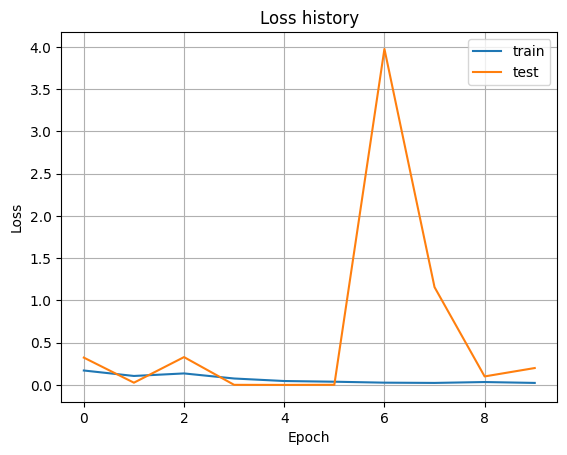

In [31]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()